# Investigating "On the time lags of the LIGO signals"

This notebook is used to investigate a number of claims made in:

https://arxiv.org/pdf/1706.04191.pdf

In the spirit of using the public LIGO data, I restrict myself here to only using code, and data products that are available through the LIGO Open Science Center (LOSC). Many of the functions/routines are copy/pasted directly from the LOSC examples

https://losc.ligo.org/tutorials/

I'd also refer an interested reader here, for some more examples of LIGO data analysis with open-source codes:

http://ligo-cbc.github.io/pycbc/latest/html/

The notebook begins with a bunch of function declarations/imports so you would need to scroll through those to get to the main results. Scroll down to "Now we do stuff" if you just want to look at plots

### As always, we start with a bunch of imports/definitions

In [1]:
# the IPython magic below must be commented out in the .py file, since it doesn't work there.
%matplotlib nbagg
#%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sns
sns.set_context("notebook")
sns.set_style("ticks")
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib import rcParams
scale_fac = 0.8
rcParams['figure.figsize'] = (10.0*scale_fac, 8.0*scale_fac)
#font
rcParams['font.sans-serif']=['Fira Sans OT']
SMALL_SIZE = 15
MEDIUM_SIZE = 15
BIGGER_SIZE = 15

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

#rcParams['font.size'] = 15
rcParams['legend.fontsize'] = 'medium'
#tick label spacing and tick width
rcParams['xtick.major.pad'] = 4
rcParams['ytick.major.pad'] = 5
rcParams['xtick.major.width'] = 1
rcParams['ytick.major.width'] = 1
#legend style
rcParams['legend.frameon'] = False
rcParams['legend.numpoints'] = 3



# Standard python numerical analysis imports:
import numpy as np
from scipy import signal
from scipy.interpolate import interp1d
from scipy.signal import butter, filtfilt, iirdesign, zpk2tf, freqz
import h5py
import json

# LIGO-specific readligo.py 
import readligo as rl

# you might get a matplotlib warning here; you can ignore it.

# constants:
clight = 2.99792458e8                # m/s
G = 6.67259e-11                      # m^3/kg/s^2 
MSol = 1.989e30                      # kg


In [2]:
# LOSC provides a JSON file with parameters of the event

fnjson = "O1_events.json"
try:
    events = json.load(open(fnjson,"r"))
except IOError:
    print("Cannot find resource file "+fnjson)
    print("You can download it from https://losc.ligo.org/s/events/"+fnjson)
    print("Quitting.")
    quit()


In [3]:
# Read parameters from the JSON file (also showing GW151226 as an example)

# Params for GW150914
event_GW150914 = events['GW150914']
fn_H1_GW150914 = event_GW150914['fn_H1']              # File name for H1 data
fn_L1_GW150914 = event_GW150914['fn_L1']              # File name for L1 data
fn_template_GW150914 = event_GW150914['fn_template']  # File name for template waveform
fs_GW150914 = event_GW150914['fs']                    # Set sampling rate
tevent_GW150914 = event_GW150914['tevent']            # Set approximate event GPS time
fband_GW150914 = event_GW150914['fband']              # frequency band for bandpassing signal

# And for GW151226
event_GW151226 = events['GW151226']
fn_H1_GW151226 = event_GW151226['fn_H1']              # File name for H1 data
fn_L1_GW151226 = event_GW151226['fn_L1']              # File name for L1 data
fn_template_GW151226 = event_GW151226['fn_template']  # File name for template waveform
fs_GW151226 = event_GW151226['fs']                    # Set sampling rate
tevent_GW151226 = event_GW151226['tevent']            # Set approximate event GPS time
fband_GW151226 = event_GW151226['fband']              # frequency band for bandpassing signal


In [4]:
# We have a bunch of different data files. I didn't end up using all of these in the results below,
# but I keep this here anyway.

# Read in data files
strain_H1_GW150914, time_H1_GW150914, chan_dict_H1_GW150914 = rl.loaddata(fn_H1_GW150914, 'H1')
strain_L1_GW150914, time_L1_GW150914, chan_dict_L1_GW150914 = rl.loaddata(fn_L1_GW150914, 'L1')
strain_H1_GW150914_H, time_H1_GW150914_H, chan_dict_H1_GW150914_H = rl.loaddata('H-H1_LOSC_16_V1-1167559920-32.hdf5', 'H1')
strain_L1_GW150914_H, time_L1_GW150914_H, chan_dict_L1_GW150914_H = rl.loaddata('L-L1_LOSC_16_V1-1167559920-32.hdf5', 'L1')
strain_H1_GW150914_L, time_H1_GW150914_L, chan_dict_H1_GW150914_L = rl.loaddata('H-H1_LOSC_4_V1-1167557888-4096.hdf5', 'H1')
strain_L1_GW150914_L, time_L1_GW150914_L, chan_dict_L1_GW150914_L = rl.loaddata('L-L1_LOSC_4_V1-1167557888-4096.hdf5', 'L1')

strain_H1_GW151226, time_H1_GW151226, chan_dict_H1_GW151226 = rl.loaddata(fn_H1_GW151226, 'H1')
strain_L1_GW151226, time_L1_GW151226, chan_dict_L1_GW151226 = rl.loaddata(fn_L1_GW151226, 'L1')

In [5]:
# Define whitening, highpass-filter and a cross-correlation routine

from scipy import signal

def highpass_filter(y, sr):
    filter_stop_freq = 15  # Hz
    filter_pass_freq = 30 # Hz
    filter_order = 1001

    # High-pass filter
    nyquist_rate = sr / 2.
    desired = (0, 0, 1, 1)
    bands = (0, filter_stop_freq, filter_pass_freq, nyquist_rate)
    filter_coefs = signal.firls(filter_order, bands, desired, nyq=nyquist_rate)

    # Apply high-pass filter
    filtered_audio = signal.filtfilt(filter_coefs, [1], y)
    return filtered_audio

def whiten(strain, interp_psd, dt):
    Nt = len(strain)
    freqs = np.fft.rfftfreq(Nt, dt)

    # whitening: transform to freq domain, divide by asd, then transform back, 
    # taking care to get normalization right.
    hf = np.fft.rfft(strain)
    white_hf = hf / (np.sqrt(interp_psd(freqs) /dt/2.))
    white_ht = np.fft.irfft(white_hf, n=Nt)
    return white_ht


def correlation(s1, s2):
    return sum(s1 * s2)


In [6]:
# Read in best-fit template waveform function.
# This is copied directly from the LOSC example. See there for more explanation.

def read_template(event, psd_H1, psd_L1,time, eventname):
    tmplt = {}
    f_template = h5py.File(event['fn_template'], "r")
    # extract metadata from the template file:
    template_p, template_c = f_template["template"][...]
    tmplt['template_p'] = template_p
    tmplt['template_c'] = template_c
    dt = 1. / f_template["/meta"].attrs['fs']
    t_m1 = f_template["/meta"].attrs['m1']
    t_m2 = f_template["/meta"].attrs['m2']
    t_a1 = f_template["/meta"].attrs['a1']
    t_a2 = f_template["/meta"].attrs['a2']
    t_approx = f_template["/meta"].attrs['approx']
    f_template.close()
    # the template extends to roughly 16s, zero-padded to the 32s data length. The merger will be roughly 16s in.
    template_offset = 16.
    tmplt['offset'] = template_offset
    # whiten the templates:
    template_p_whiten = whiten(template_p,psd_H1,dt)
    template_c_whiten = whiten(template_c,psd_H1,dt)
    tmplt['template_p_whiten'] = template_p_whiten
    tmplt['template_c_whiten'] = template_c_whiten
    bb, ab = butter(4, [event['fband'][0]*2./event['fs'], event['fband'][1]*2./event['fs']], btype='band')
    template_p_whitenbp = filtfilt(bb, ab, template_p_whiten)
    template_c_whitenbp = filtfilt(bb, ab, template_c_whiten)
    tmplt['template_p_whitenbp'] = template_p_whitenbp
    tmplt['template_c_whitenbp'] = template_c_whitenbp
    return tmplt


In [7]:
# Generate a PSD.
# Again this is stripped down from the LOSC example, see there for more discussion of parameters used here.

def make_psd(strain_H1, strain_L1, event_params, event_name, autoscale_y=False):
    fs = event_params['fs']
    # number of sample for the fast fourier transform:
    NFFT = int(4*fs)
    Pxx_H1, freqs = mlab.psd(strain_H1, Fs = fs, NFFT = NFFT)
    Pxx_L1, freqs = mlab.psd(strain_L1, Fs = fs, NFFT = NFFT)

    # We will use interpolations of the ASDs computed above for whitening:
    psd_H1 = interp1d(freqs, Pxx_H1)
    psd_L1 = interp1d(freqs, Pxx_L1)
    return psd_H1, psd_L1


In [8]:
# Define the matched-filter to determine how to remove tmplt from data.
# Guess where this came from? That's right, LOSC.


def run_matched_filter(event, tmplt, time, strain_H1, strain_L1, strain_H1_whitenbp, strain_L1_whitenbp, psd_H1, psd_L1):
    # -- To calculate the PSD of the data, choose an overlap and a window (common to all detectors)
    #   that minimizes "spectral leakage" https://en.wikipedia.org/wiki/Spectral_leakage
    data_removed = {}
    fs = event['fs']
    tevent = event['tevent']
    NFFT = 4*fs
    psd_window = np.blackman(NFFT)
    # and a 50% overlap:
    NOVL = NFFT/2

    # define the complex template, common to both detectors:
    template = (tmplt['template_p'] + tmplt['template_c']*1.j) 
    # We will record the time where the data match the END of the template.
    etime = time+tmplt['offset']
    # the length and sampling rate of the template MUST match that of the data.
    datafreq = np.fft.fftfreq(template.size)*fs
    df = np.abs(datafreq[1] - datafreq[0])
    
    # to remove effects at the beginning and end of the data stretch, window the data
    # https://en.wikipedia.org/wiki/Window_function#Tukey_window
    try:   dwindow = signal.tukey(template.size, alpha=1./8)  # Tukey window preferred, but requires recent scipy version 
    except: dwindow = signal.blackman(template.size)          # Blackman window OK if Tukey is not available

    # prepare the template fft.
    template_fft = np.fft.fft(template*dwindow) / fs

    # loop over the detectors
    dets = ['H1', 'L1']
    for det in dets:
        print det
        if det is 'L1': 
            data = strain_L1.copy()
            psd = psd_L1
        else:
            data = strain_H1.copy()
            psd = psd_H1
            
    
        # -- Calculate the PSD of the data.  Also use an overlap, and window:
        data_psd, freqs = mlab.psd(data, Fs = fs, NFFT = NFFT, window=psd_window, noverlap=NOVL)

        # Take the Fourier Transform (FFT) of the data and the template (with dwindow)
        data_fft = np.fft.fft(data*dwindow) / fs

        # -- Interpolate to get the PSD values at the needed frequencies
        power_vec = np.interp(np.abs(datafreq), freqs, data_psd)
        
        # -- Calculate the matched filter output in the time domain:
        # Multiply the Fourier Space template and data, and divide by the noise power in each frequency bin.
        # Taking the Inverse Fourier Transform (IFFT) of the filter output puts it back in the time domain,
        # so the result will be plotted as a function of time off-set between the template and the data:
        optimal = data_fft * template_fft.conjugate() / power_vec
        optimal_time = 2*np.fft.ifft(optimal)*fs

        # -- Normalize the matched filter output:
        # Normalize the matched filter output so that we expect a value of 1 at times of just noise.
        # Then, the peak of the matched filter output will tell us the signal-to-noise ratio (SNR) of the signal.
        sigmasq = 1*(template_fft * template_fft.conjugate() / power_vec).sum() * df
        sigma = np.sqrt(np.abs(sigmasq))
        SNR_complex = optimal_time/sigma

        # shift the SNR vector by the template length so that the peak is at the END of the template
        peaksample = int(data.size / 2)  # location of peak in the template
        SNR_complex = np.roll(SNR_complex,peaksample)
        SNR = abs(SNR_complex)

        # find the time and SNR value at maximum:
        indmax = np.argmax(SNR)
        timemax = time[indmax]
        SNRmax = SNR[indmax]

        # Calculate the "effective distance" (see FINDCHIRP paper for definition)
        # d_eff = (8. / SNRmax)*D_thresh
        d_eff = sigma / SNRmax
        # -- Calculate optimal horizon distnace
        horizon = sigma/8

        # Extract time offset and phase at peak
        phase = np.angle(SNR_complex[indmax])
        offset = (indmax-peaksample)
        #print offset

        # apply time offset, phase, and d_eff to whitened template, for plotting
        template_p_whitenbp = tmplt['template_p_whitenbp']
        template_c_whitenbp = tmplt['template_c_whitenbp']
        template_whitened = (template_p_whitenbp + template_c_whitenbp*1.j) 
        template_phaseshifted = np.real(template_whitened*np.exp(1j*phase))
        template_match = np.roll(template_phaseshifted,offset) / d_eff
    
        print('For detector {0}, maximum at {1:.4f} with SNR = {2:.1f}, D_eff = {3:.2f}, horizon = {4:0.1f} Mpc' 
              .format(det,timemax,SNRmax,d_eff,horizon))

        # plotting changes for the detectors:
        if det is 'L1': 
            pcolor='g'
            strain_whitenbp = strain_L1_whitenbp
        else:
            pcolor='r'
            strain_whitenbp = strain_H1_whitenbp
        
        data_removed[det] = {}
        data_removed[det]['times'] = time-tevent
        data_removed[det]['data'] = strain_whitenbp-template_match
        
    return data_removed


## Now we do stuff

In [9]:
# Generate PSD
psd_H1_GW150914, psd_L1_GW150914 = make_psd(strain_H1_GW150914_L, strain_L1_GW150914_L, event_GW150914, 'GW150914')

# Read in the two templates
tmplt_GW150914 = read_template(event_GW150914, psd_H1_GW150914, psd_L1_GW150914, time_H1_GW150914, 'GW150914')
#tmplt_GW151226 = read_template(event_GW151226,psd_H1_GW151226, psd_L1_GW151226,time_H1_GW151226, 'GW151226')

# now whiten the data from H1 and L
dt = time_H1_GW150914[1] - time_H1_GW150914[0]
strain_H1_whiten_GW150914 = whiten(strain_H1_GW150914,psd_H1_GW150914,dt)
strain_L1_whiten_GW150914 = whiten(strain_L1_GW150914,psd_L1_GW150914,dt)

# Run matched-filter to get subtracted data
data_removed = run_matched_filter(event_GW150914, tmplt_GW150914, time_H1_GW150914, strain_H1_GW150914, strain_L1_GW150914,
                   strain_H1_whiten_GW150914, strain_L1_whiten_GW150914, psd_H1_GW150914, psd_L1_GW150914)



H1
For detector H1, maximum at 1126259462.4414 with SNR = 18.6, D_eff = 805.83, horizon = 1873.7 Mpc
L1
For detector L1, maximum at 1126259462.4343 with SNR = 13.3, D_eff = 979.07, horizon = 1623.6 Mpc


<IPython.core.display.Javascript object>


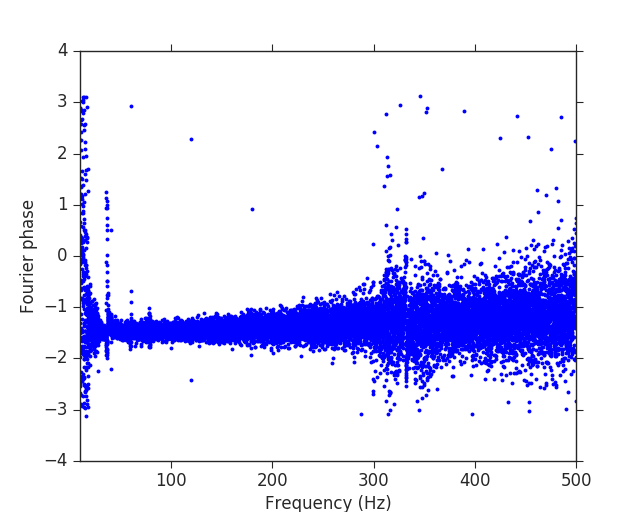

<IPython.core.display.Javascript object>


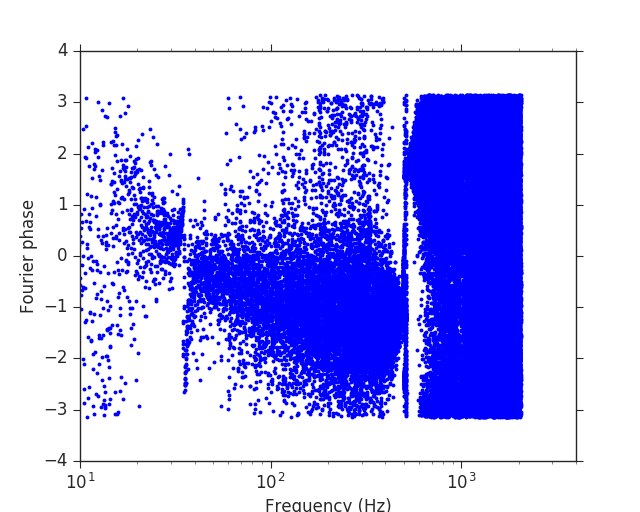

In [10]:
# Reproduce the Fourier coefficent correlation in the raw data.
# This is reproducing Figure 3 plot from the paper, using raw data

# First plot the H1 data
hf = np.fft.rfft(strain_H1_GW150914)
df = 1./ 32.
farr = np.arange(len(hf)) * df

plt.figure()
plt.plot(farr, np.angle(hf),'b.')
plt.xlim([10,500])
plt.ylabel('Fourier phase')
plt.xlabel('Frequency (Hz)')

# And then the L1 data
# Note that shifting start/end times a little here results in a plot much like the H1 plot
hf = np.fft.rfft(strain_L1_GW150914)
df = 1./ 32.
farr = np.arange(len(hf)) * df

plt.figure()
plt.semilogx(farr, np.angle(hf),'b.')
plt.xlim([10,4000])
plt.ylabel('Fourier phase')
plt.xlabel('Frequency (Hz)')




<IPython.core.display.Javascript object>


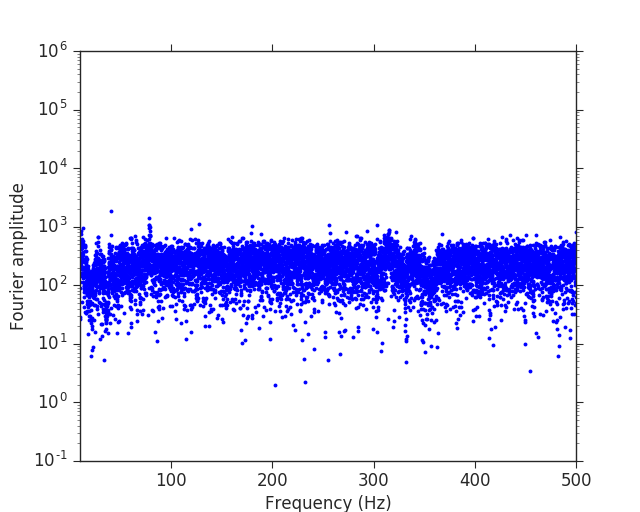

<IPython.core.display.Javascript object>


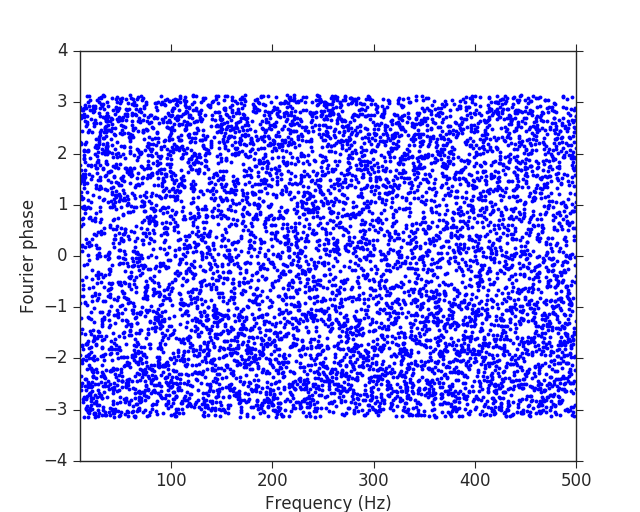

<IPython.core.display.Javascript object>


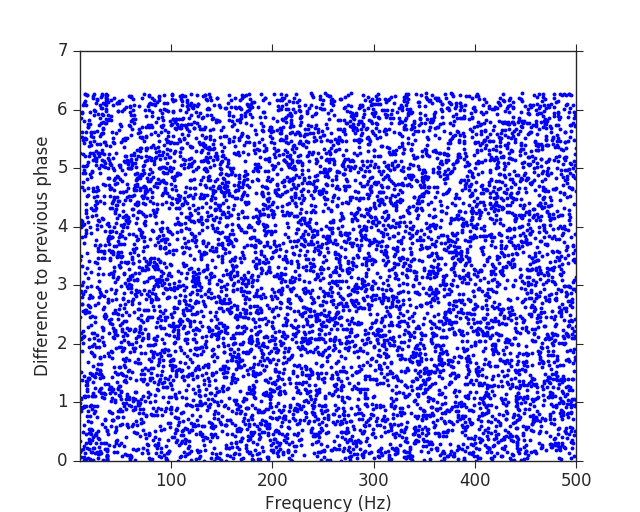

<IPython.core.display.Javascript object>


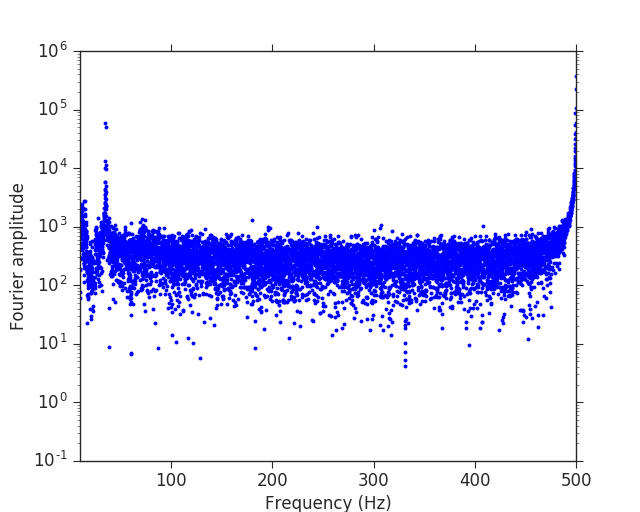

<IPython.core.display.Javascript object>


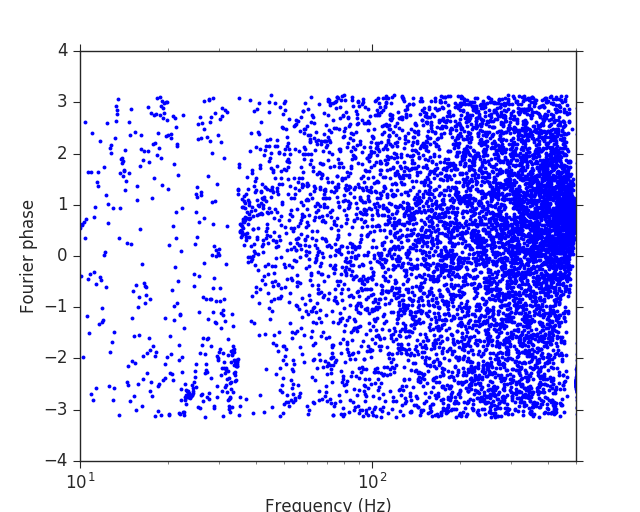

<IPython.core.display.Javascript object>


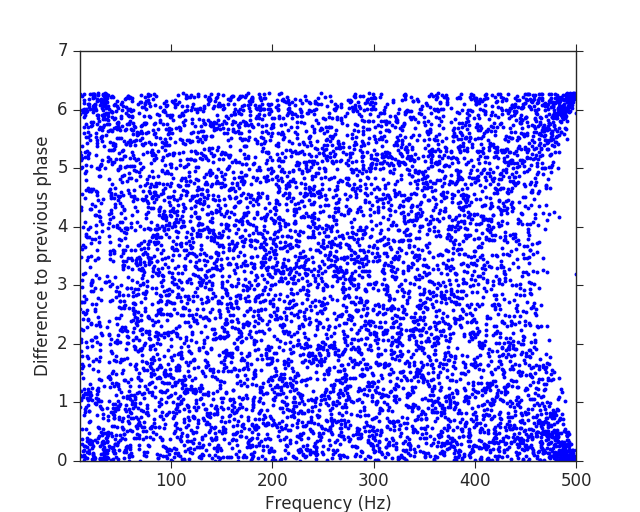

In [11]:
# Then repeat the exercise with whitened data. Hanford first

# whitened data will be corrupted on ends, so use middle 16s
hf = np.fft.rfft(strain_H1_whiten_GW150914[8*4096:24*4096])
df = 1./ 16.
farr = np.arange(len(hf)) * df

angl = np.angle(hf)
power = np.abs(hf)
diff_angl = angl[:-1] - angl[1:]
diff_angl[diff_angl < 0] += 2*np.pi

# Plot Fourier amplitude (did we whiten adequately?)
plt.figure()
plt.semilogy(farr, power,'b.')
plt.xlim([10,500])
plt.ylabel('Fourier amplitude')
plt.xlabel('Frequency (Hz)')

# Plot Fourier phases, should be uncorrelated only if truly whitened.
plt.figure()
plt.plot(farr, np.angle(hf),'b.')
plt.xlim([10,500])
plt.ylabel('Fourier phase')
plt.xlabel('Frequency (Hz)')

# Plot differences between adjacent frequencies, as in Figure 3, again should be random if truly whitened
plt.figure()
plt.plot(farr[:-1], diff_angl,'b.')
plt.xlim([10,500])
plt.ylabel('Difference to previous phase')
plt.xlabel('Frequency (Hz)')


# Now we repeat the same 3 plots for Livingston.

# Note that shifting the start/end times a little here results in a plot much like the H1 plot. Maybe the chosen
# times results in start/end points whose values are similar, which will weaken the observed correlations.
hf = np.fft.rfft(strain_L1_whiten_GW150914[8*4096:24*4096])
df = 1./ 16.
farr = np.arange(len(hf)) * df
angl = np.angle(hf)
diff_angl = angl[:-1] - angl[1:]
diff_angl[diff_angl < 0] += 2*np.pi
power = np.abs(hf)

# Note: Whitening did not perfectly remove spectral lines in this case. So these are still present.
plt.figure()
plt.semilogy(farr, power,'b.')
plt.xlim([10,500])
plt.ylabel('Fourier amplitude')
plt.xlabel('Frequency (Hz)')

# Because data is not perfectly whitened, some correlations persist.
plt.figure()
plt.semilogx(farr, np.angle(hf),'b.')
plt.xlim([10,500])
plt.ylabel('Fourier phase')
plt.xlabel('Frequency (Hz)')

plt.figure()
plt.plot(farr[:-1], diff_angl,'b.')
plt.xlim([10,500])
plt.ylabel('Difference to previous phase')
plt.xlabel('Frequency (Hz)')


<IPython.core.display.Javascript object>


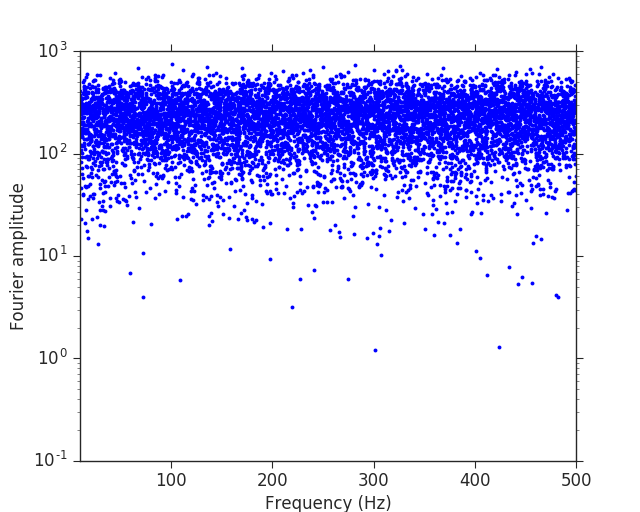

<IPython.core.display.Javascript object>


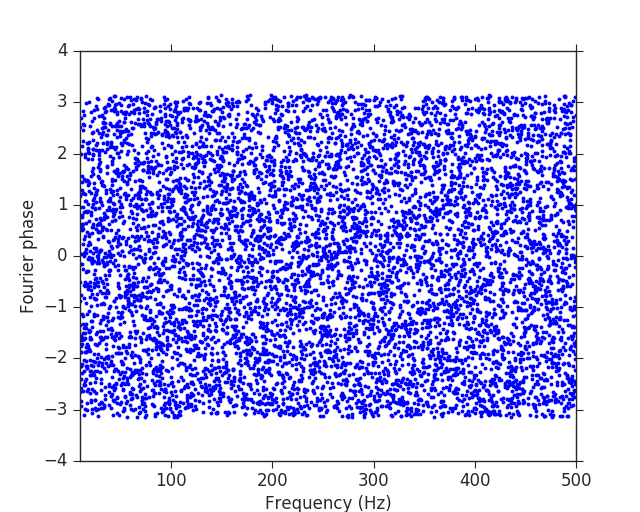

<IPython.core.display.Javascript object>


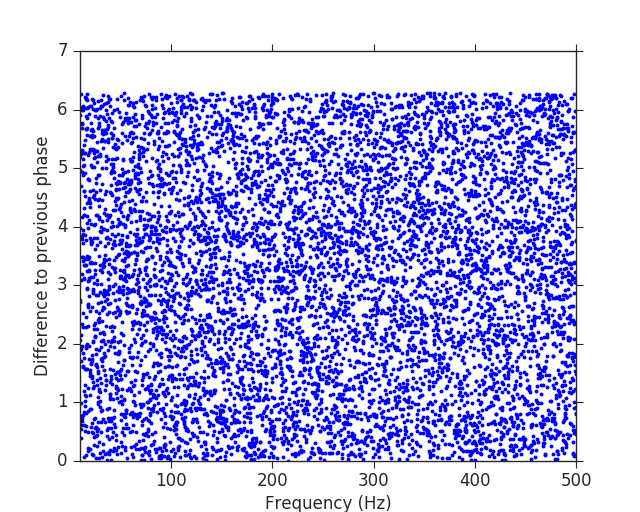

In [12]:
# Let's try to reproduce this behaviour with *actual* Gaussian noise

# This performs the inverse of the "whiten" function defined above
def unwhiten(strain, interp_psd, dt):
    Nt = len(strain)
    freqs = np.fft.rfftfreq(Nt, dt)

    # whitening: transform to freq domain, divide by asd, then transform back, 
    # taking care to get normalization right.
    hf = np.fft.rfft(strain)
    white_hf = hf * (np.sqrt(interp_psd(freqs) /dt/2.))
    white_ht = np.fft.irfft(white_hf, n=Nt)
    return white_ht


# Generate some Gaussian noise, 128s at 4096Hz.
np.random.seed(1)
data = np.random.normal(size=4096*128)

# Verify that it *is* Gaussian. These 3 plots show amplitudes and phases of the whitened noise. Of course, this
# is consistent with Gaussian noise.
df = 1./ 16.
hf = np.fft.rfft(data[16*4096:32*4096])
farr = np.arange(len(hf)) * df

angl = np.angle(hf)
power = np.abs(hf)
diff_angl = angl[:-1] - angl[1:]
diff_angl[diff_angl < 0] += 2*np.pi

plt.figure()
plt.semilogy(farr, power,'b.')
plt.xlim([10,500])
plt.ylabel('Fourier amplitude')
plt.xlabel('Frequency (Hz)')

plt.figure()
plt.plot(farr, angl,'b.')
plt.xlim([10,500])
plt.ylabel('Fourier phase')
plt.xlabel('Frequency (Hz)')

plt.figure()
plt.plot(farr[:-1], diff_angl,'b.')
plt.xlim([10,500])
plt.ylabel('Difference to previous phase')
plt.xlabel('Frequency (Hz)')



<IPython.core.display.Javascript object>


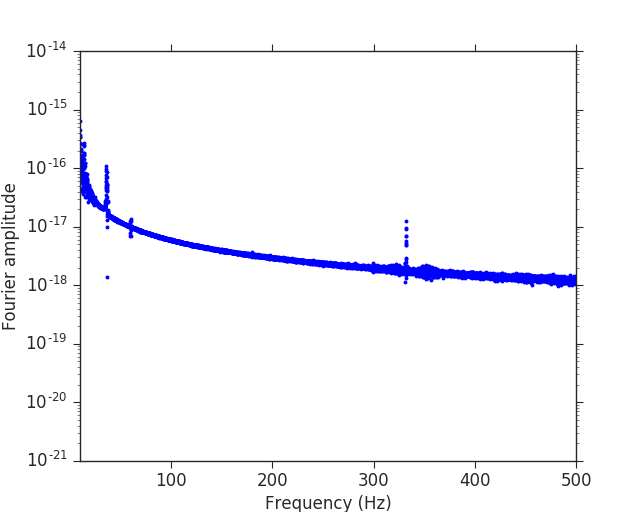

<IPython.core.display.Javascript object>


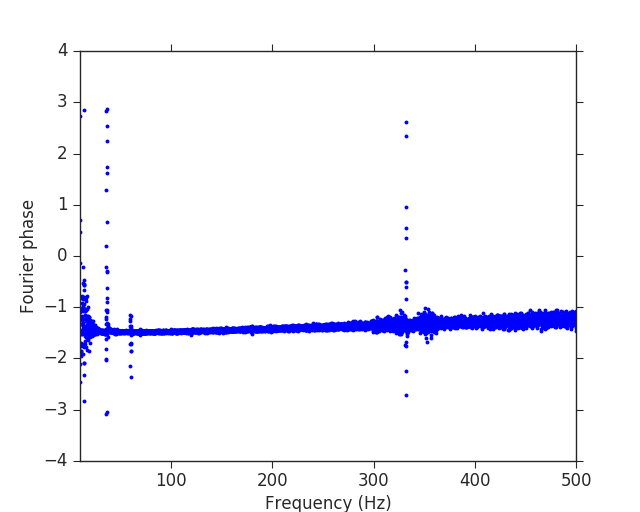

<IPython.core.display.Javascript object>


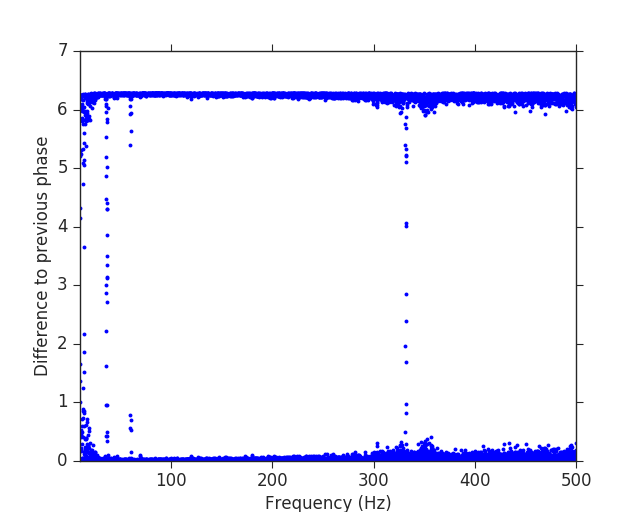

In [13]:
# Then let's color the data, by inverting the "whiten" function. This data will still be Gaussian, but not "white"
# Gaussian noise.
colored_gaussian = unwhiten(data, psd_H1_GW150914, 1./4096.)
df = 1./ 16.
# As this data *will* by cyclical (ie. point 0 and point -1 are directly connected), we take 16s of the full data.
hf = np.fft.rfft(colored_gaussian[16*4096:32*4096])
farr = np.arange(len(hf)) * df

# Then we make the familiar 3 plots. These show very strong correlations.
# This is *not* a sign the data is not Gaussian, as of course this data *is* Gaussian.
angl = np.angle(hf)
power = np.abs(hf)
diff_angl = angl[:-1] - angl[1:]
diff_angl[diff_angl < 0] += 2*np.pi

plt.figure()
plt.semilogy(farr, power,'b.')
plt.xlim([10,500])
plt.ylabel('Fourier amplitude')
plt.xlabel('Frequency (Hz)')

plt.figure()
plt.plot(farr, angl,'b.')
plt.xlim([10,500])
plt.ylabel('Fourier phase')
plt.xlabel('Frequency (Hz)')

plt.figure()
plt.plot(farr[:-1], diff_angl,'b.')
plt.xlim([10,500])
plt.ylabel('Difference to previous phase')
plt.xlabel('Frequency (Hz)')


<IPython.core.display.Javascript object>


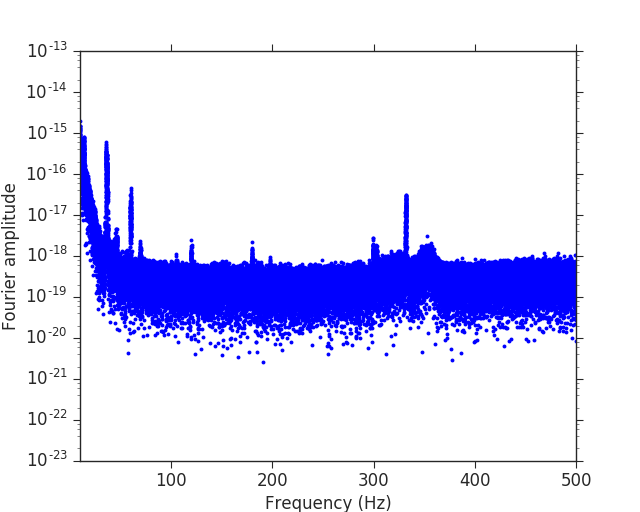

<IPython.core.display.Javascript object>


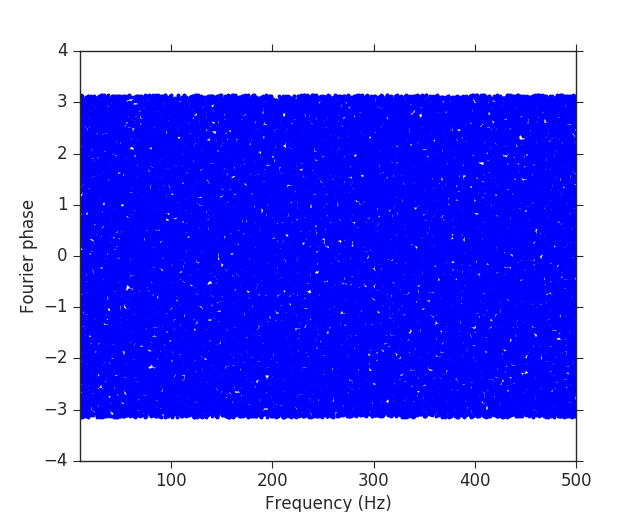

<IPython.core.display.Javascript object>


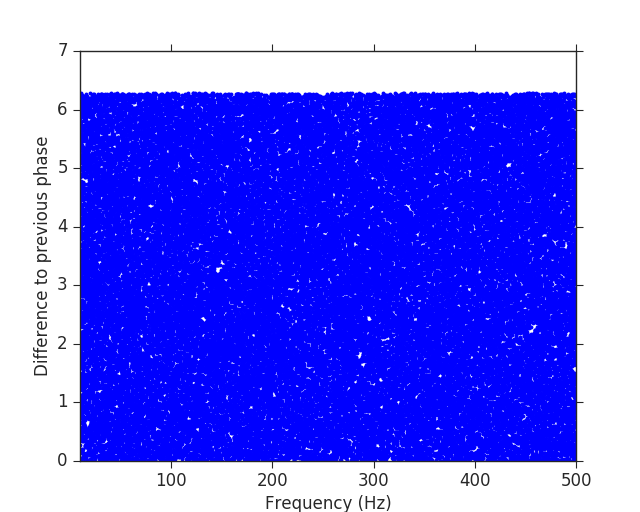

In [14]:
# Finally if we show *all* of the colored noise, which has no discontinuity, it looks Gaussian
df = 1./ 128.
hf = np.fft.rfft(colored_gaussian)
farr = np.arange(len(hf)) * df

angl = np.angle(hf)
power = np.abs(hf)
diff_angl = angl[:-1] - angl[1:]
diff_angl[diff_angl < 0] += 2*np.pi

plt.figure()
plt.semilogy(farr, power,'b.')
plt.xlim([10,500])
plt.ylabel('Fourier amplitude')
plt.xlabel('Frequency (Hz)')

plt.figure()
plt.plot(farr, angl,'b.')
plt.xlim([10,500])
plt.ylabel('Fourier phase')
plt.xlabel('Frequency (Hz)')

plt.figure()
plt.plot(farr[:-1], diff_angl,'b.')
plt.xlim([10,500])
plt.ylabel('Difference to previous phase')
plt.xlabel('Frequency (Hz)')


<IPython.core.display.Javascript object>


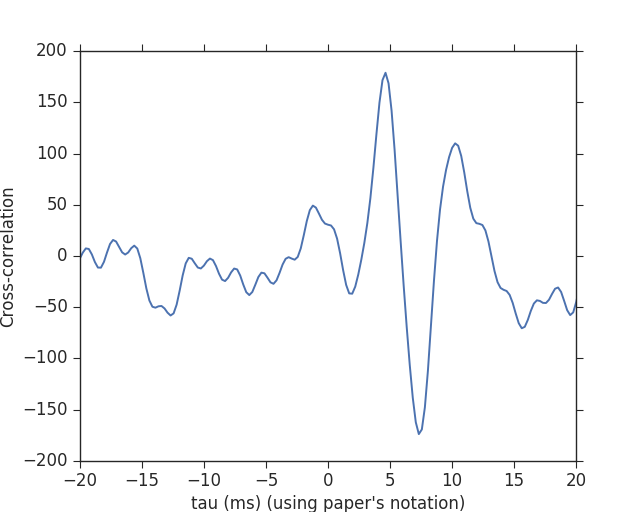

<IPython.core.display.Javascript object>


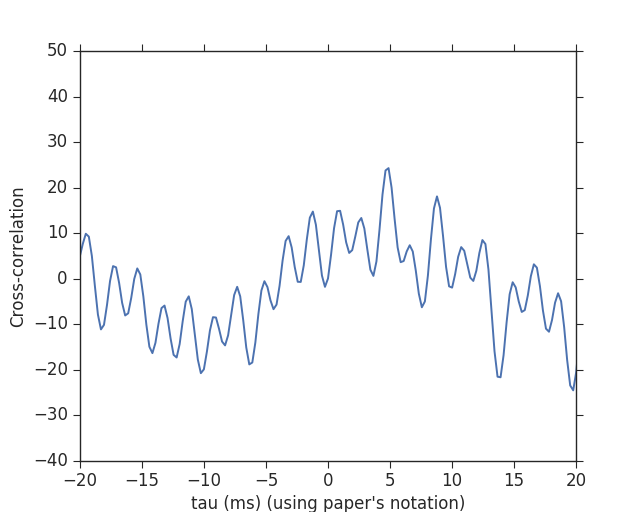

In [15]:
# Now we try to reproduce Figure 7: Look for correlations in the cleaned noise

# Whiten and bandpass data
y = whiten(strain_H1_GW150914, psd_H1_GW150914, 1./4096.)
z = whiten(strain_L1_GW150914, psd_L1_GW150914, 1./4096.)
bb, ab = butter(4, [20.*2./fs_GW150914, 400.*2./fs_GW150914], btype='band')
Y = filtfilt(bb, ab, y)
Z = filtfilt(bb, ab, z)

# Compute correlations for various values of dt

# Choose time window: The paper use both 0.2s and 0.02s. I saw no correlations with either after removal of the event.
deltat = 0.02
indxt = np.where((time_H1_GW150914 >= tevent_GW150914-deltat) & (time_H1_GW150914 < tevent_GW150914+deltat))
tmp_arr = np.arange(len(time_H1_GW150914))[indxt]
min_indxt = min(tmp_arr)
max_indxt = max(tmp_arr)

corrs = []
for i in range(-400,400):
    corrs.append(correlation(Y[min_indxt:max_indxt], Z[min_indxt+i:max_indxt+i]))

# Here the signal is visible. Haven't removed the event yet!
plt.figure()
plt.plot(-np.arange(-400,400)*1./4096. * 1000.,corrs)
plt.xlim(-20,20)
plt.xlabel("tau (ms) (using paper's notation)")
plt.ylabel("Cross-correlation")

# Repeat on the whitened removed-signal data
H1d = data_removed['H1']['data']
L1d = data_removed['L1']['data']

H1d = filtfilt(bb, ab, H1d)
L1d = filtfilt(bb, ab, L1d)

corrs = []
for i in range(-400,400):
    corrs.append(correlation(H1d[min_indxt:max_indxt], L1d[min_indxt+i:max_indxt+i]))

# Here the signal is *not* visible.
plt.figure()
plt.plot(-np.arange(-400,400)*1./4096. * 1000.,corrs)
plt.xlim(-20,20)
plt.xlabel("tau (ms) (using paper's notation)")
plt.ylabel("Cross-correlation")




<IPython.core.display.Javascript object>


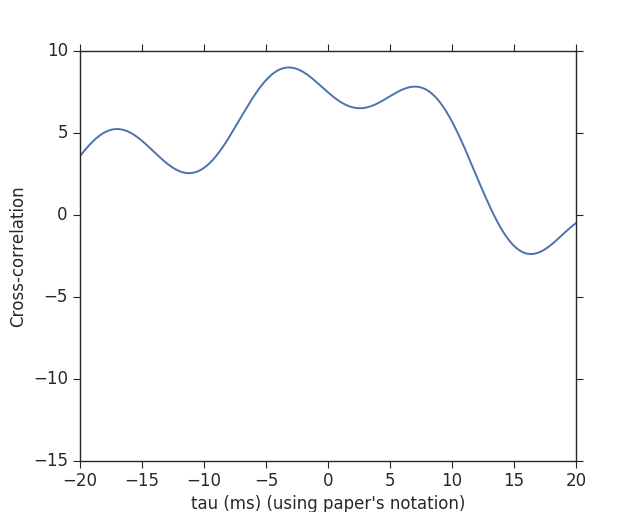

In [16]:
# Let's try this again with the data from Figure 1 of the PRL
# Note tht this plot does look different. This is due to different conditioning done to the data
# ie. the choices for low/high pass filtering.

h1_residual_data = np.loadtxt('fig1-residual-H.txt')
l1_residual_data = np.loadtxt('fig1-residual-L.txt')
h1_res_times = h1_residual_data[:,0]
h1_res_strain = h1_residual_data[:,1]
l1_res_times = l1_residual_data[:,0]
l1_res_strain = l1_residual_data[:,1]

# Select times
indxt = np.where((h1_res_times >= 0.39) & (h1_res_times < 0.43))
tmp_arr = np.arange(len(time_H1_GW150914))[indxt]
min_indxt = min(tmp_arr)
max_indxt = max(tmp_arr)

corrs = []
for i in range(-400,400):
    corrs.append(correlation(h1_res_strain[min_indxt:max_indxt], l1_res_strain[min_indxt+i:max_indxt+i]))

# Make correlation plot
plt.figure()
plt.plot(-np.arange(-400,400)*1./4096. * 1000.,corrs)
plt.xlim(-20,20)
plt.xlabel("tau (ms) (using paper's notation)")
plt.ylabel("Cross-correlation")
